<a href="https://colab.research.google.com/github/Lukas-Swc/neural-network-course/blob/main/03_keras/05_tensorboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Callbacks - wywołania zwrotne

1. [Budowa sieci neuronowej](#a0)
2. [Trenowanie modelu - Tensorflow](#a1)
2. [Tensorboard Dev](#a2)




Klasyfikator wieloklasowy - Digit Recognition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

np.set_printoptions(precision=12, suppress=True, linewidth=120)
print(tf.__version__)

2.18.0


Załadowanie i przygotowanie danych

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [3]:
print(X_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   

In [4]:
print(f'X_train[0] shape: {X_train[0].shape}')

X_train[0] shape: (28, 28)


In [5]:
X_train = X_train / 255.
X_test = X_test / 255.

Eksploracja danych

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

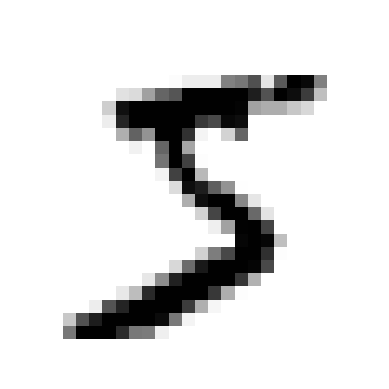

In [6]:
plt.imshow(X_train[0], cmap='gray_r')
plt.axis('off')

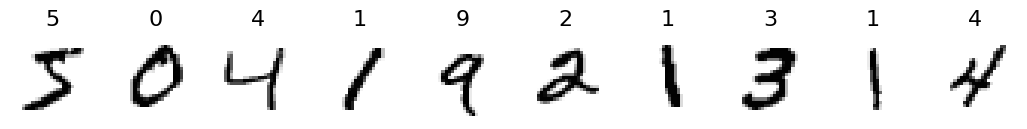

In [7]:
plt.figure(figsize=(13, 13))
for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.axis('off')
    plt.imshow(X_train[i-1], cmap='gray_r')
    plt.title(y_train[i-1], color='black', fontsize=16)
plt.show()

### <a name='a0'></a> Budowa sieci neuronowej

In [8]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=10, activation='softmax')
        ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

### <a name='a1'></a> Trenowanie modelu - Tensorboard

In [9]:
from datetime import datetime as dt

!rm -rf ./logs
log_dir = 'logs/fit/' + dt.now().strftime('%Y%m%d-%H%M%S')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [10]:
model = build_model()
history = model.fit(X_train, y_train, epochs=8, validation_split=0.2, batch_size=32, callbacks=[tensorboard])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8348 - loss: 0.5522 - val_accuracy: 0.9529 - val_loss: 0.1587
Epoch 2/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9490 - loss: 0.1738 - val_accuracy: 0.9661 - val_loss: 0.1157
Epoch 3/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9636 - loss: 0.1211 - val_accuracy: 0.9704 - val_loss: 0.0981
Epoch 4/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9695 - loss: 0.0967 - val_accuracy: 0.9734 - val_loss: 0.0939
Epoch 5/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9754 - loss: 0.0784 - val_accuracy: 0.9723 - val_loss: 0.0865
Epoch 6/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9783 - loss: 0.0705 - val_accuracy: 0.9741 - val_loss: 0.0841
Epoch 7/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9803 - loss: 0.0608 - val_accuracy: 0.9768 - val_loss: 0.0775
Epoch 8/8
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9817 - loss: 0.0545 - val

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

### <a name='a2'></a> Tensorboard Dev

In [11]:
%load_ext tensorboard

In [12]:
!tensorboard dev upload --logdir logs

2025-06-04 18:03:41.114068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749060221.145048   37831 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749060221.152559   37831 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.
